In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT
import albumentations as A
from albumentations.pytorch import ToTensorV2
from efficientnet_pytorch import EfficientNet

## DATASET

In [2]:
class KeypointsDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform):
        self.annotation = pd.read_csv(csv_file).dropna(axis=0, how='any')
        self.annotation = self.annotation.reset_index(drop=True)
        self.transform = transform
       
    def __len__(self):
        return len(self.annotation)
    
    def __getitem__(self, index):
        img = self.annotation.iloc[index]["Image"]
        image = np.array(img.split()).reshape(96, 96)
        image = np.repeat(image.reshape(96,96,1),3,2).astype(np.uint8)
        keypoints = self.annotation.iloc[index].to_numpy()[:-1].reshape(-1,2)
        augmentations = self.transform(image=image, keypoints=keypoints)
        image = augmentations["image"]
        keypoints = np.array(augmentations["keypoints"]).reshape(-1)
        return image, keypoints
    
    def __show_img_annotated__(self, index):
        img = self.annotation.iloc[index]["Image"]
        image = np.array(img.split()).astype(np.uint8).reshape(96, 96)
        #image = Image.fromarray(image, 'L')
        plt.imshow(image, cmap="gray")
        keypoints = self.annotation.iloc[index].to_numpy()[:-1].reshape(-1,2)
        plt.scatter(keypoints[:,0], keypoints[:,1], c="white")
        plt.show()

In [4]:
transform = A.Compose([A.Resize(width=96, height=96),
    ToTensorV2(),
    ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
)

In [5]:
dataset = KeypointsDataset("trainingdataset.csv", transform)

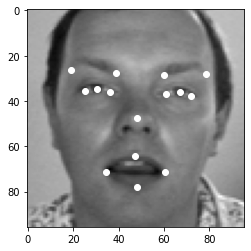

In [6]:
dataset.__show_img_annotated__(590)

In [7]:
## split data
train_size = int(np.floor(len(dataset)*0.8))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

## MODEL: efficientNet

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Sequential(nn.Linear(1280, 30))
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


## TRAINING

In [13]:
# Hyperparameters
EPOCH = 10
LR = 1e-4
BATCH_SIZE = 64
loss_function = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [14]:
train_loader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle=True)

In [16]:
def train(model):
    for epoch in range(100):
        losses = []
        num_examples = 0
        for batch in tqdm(train_loader):
            X_batch ,Y_batch = batch[0].view(-1,3,96,96).to(device), batch[1].to(device)
            output = model(X_batch.float())
            loss = loss_function(output, Y_batch.float())
            num_examples += torch.numel(Y_batch)
            losses.append(loss)
            model.zero_grad()
            loss.backward()
            optimizer.step()
           
        print(f"Loss at epoch {epoch} is {(sum(losses)/num_examples)}")

In [17]:
train(model)

  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 0 is 50.96143341064453


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 1 is 50.33932876586914


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 2 is 49.177486419677734


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 3 is 47.258663177490234


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 4 is 44.680721282958984


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 5 is 42.46852111816406


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 6 is 40.58357620239258


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 7 is 38.864295959472656


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 8 is 37.284000396728516


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 9 is 35.80854797363281


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 10 is 34.33053207397461


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 11 is 32.922508239746094


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 12 is 31.599977493286133


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 13 is 30.285558700561523


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 14 is 29.043685913085938


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 15 is 27.837926864624023


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 16 is 26.686859130859375


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 17 is 25.57805633544922


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 18 is 24.503538131713867


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 19 is 23.445098876953125


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 20 is 22.444368362426758


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 21 is 21.44338607788086


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 22 is 20.515615463256836


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 23 is 19.600059509277344


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 24 is 18.718231201171875


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 25 is 17.885602951049805


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 26 is 17.07485008239746


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 27 is 16.27524757385254


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 28 is 15.5272216796875


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 29 is 14.820208549499512


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 30 is 14.10124397277832


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 31 is 13.43232250213623


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 32 is 12.779387474060059


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 33 is 12.133086204528809


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 34 is 11.540196418762207


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 35 is 10.98190975189209


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 36 is 10.434133529663086


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 37 is 9.886183738708496


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 38 is 9.399920463562012


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 39 is 8.92560863494873


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 40 is 8.477728843688965


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 41 is 8.031255722045898


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 42 is 7.626299858093262


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 43 is 7.239758491516113


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 44 is 6.887162208557129


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 45 is 6.530094623565674


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 46 is 6.19624137878418


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 47 is 5.902271747589111


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 48 is 5.614553451538086


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 49 is 5.361255645751953


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 50 is 5.118843078613281


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 51 is 4.885901927947998


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 52 is 4.6715922355651855


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 53 is 4.481325149536133


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 54 is 4.328283786773682


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 55 is 4.163178443908691


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 56 is 4.024880409240723


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 57 is 3.8935365676879883


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 58 is 3.772831916809082


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 59 is 3.686267137527466


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 60 is 3.5888001918792725


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 61 is 3.4985291957855225


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 62 is 3.4409682750701904


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 63 is 3.382718801498413


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 64 is 3.3148889541625977


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 65 is 3.2773830890655518


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 66 is 3.2278358936309814


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 67 is 3.196019411087036


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 68 is 3.1742870807647705


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 69 is 3.1427955627441406


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 70 is 3.124539852142334


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 71 is 3.1003053188323975


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 72 is 3.0952320098876953


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 73 is 3.0737509727478027


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 74 is 3.069413661956787


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 75 is 3.0638909339904785


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 76 is 3.0577290058135986


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 77 is 3.0424094200134277


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 78 is 3.0384302139282227


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 79 is 3.0359060764312744


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 80 is 3.032379388809204


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 81 is 3.025686740875244


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 82 is 3.0334973335266113


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 83 is 3.0268449783325195


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 84 is 3.0273597240448


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 85 is 3.030388355255127


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 86 is 3.0264687538146973


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 87 is 3.0367562770843506


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 88 is 3.022143602371216


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 89 is 3.0165843963623047


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 90 is 3.013495683670044


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 91 is 3.0085153579711914


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 92 is 3.018828868865967


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 93 is 3.0108063220977783


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 94 is 3.0084619522094727


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 95 is 3.0101912021636963


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 96 is 3.018608808517456


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 97 is 3.007972240447998


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Loss at epoch 98 is 3.0131990909576416


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:21<00:00,  1.28it/s]

Loss at epoch 99 is 3.0117313861846924
